## $$ H = 4E_C n_q^2 - 2E_J \cos(\phi) + \alpha E_J \cos(2\phi - \phi_{ext}) $$
## $$ E_J / E_C = 100 \quad , \quad \phi_{ext} = 0.01\pi $$
%## $$ %\rightarrow \quad H = 0.04 n_q^2 - 2 \cos(\phi) + \alpha \cos(2\phi - 0.001\pi) $$
## With $\alpha \in [0.5;1]$.. The following is in the $n_q$ basis.

## $$ e^{-i\phi} \rightarrow FT \rightarrow \sum_i |n><n+1|$$
## $$ e^{-i2\phi} \rightarrow FT \rightarrow \sum_i |n><n+2|$$

In [3]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('C:/Users/jv97/github/Quantum-Optimal-Control/scripts')

from SimulatedAnnealing import SimulatedAnnealing, UniformSampler, GaussianSampler

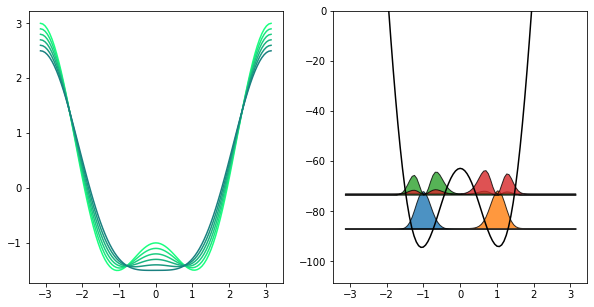

In [4]:
phi_ext = 0.001*t.pi
EJ = 2*t.pi*10 #GHz
EC = EJ/400
def plot_potential(N=101):
    phi = t.linspace(-np.pi,np.pi,N)
    fig, ax = plt.subplots(figsize=(10,5),ncols=2)
    for alpha in np.arange(1,0.4,-0.1):
        ax[0].plot(phi, -2*t.cos(phi) + alpha*t.cos(2*phi - phi_ext),c=(0.1,alpha,0.5))
    
    double_diff = (t.diag(-2*t.ones(N)) + t.diag(t.ones(N-1),1) + t.diag(t.ones(N-1),-1)).type(t.complex128)
    dphi = (phi[1:] - phi[:-1]).mean().item()
    KinE = -4*EC/dphi**2*double_diff
    V_E = -2*EJ*t.diag(t.cos(phi)) + EJ*t.diag(t.cos(2*phi - phi_ext))

    eigvals, eigvecs = t.linalg.eigh(KinE + V_E)
    eigvecs = eigvecs.T

    ax[1].plot(phi,-2*EJ*t.cos(phi) + EJ*t.cos(2*phi - phi_ext),'k')
    indices = [0,1,2,3]
    for i in indices:
        ax[1].fill_between(phi,t.abs(eigvecs[i])**2*2*EJ+eigvals[i],eigvals[i],label='n=%d'%i,edgecolor='k',alpha=0.8)
    ax[1].set_ylim(None,0)
    return #eigvals[:21]

plot_potential(N=101)

- I have checked that is is in agreeance with the flux basis, and that you need higher resolution for the flux basis to achieve the same precision that the charge basis gets with lower resolution.

- I have also checked that to change between the two simply seems to be a dfft, ie. ( ft = t.fft.ifft(eigvecs\[0\])*np.sqrt(N) to go from charge to flux ) except that the ordering of 'ft' is now \[0,..,+max_freq,-max_freq,...,-0.001\] (see torch.fft.fftshift docs)

In [5]:
N = 21
q = t.linspace(-(N - 1)//2,N//2,N)

q_mat = t.diag(q)
def V_mat(alpha=1):
    return -EJ*(t.diag(t.ones(N-1,dtype=t.complex128),-1) + t.diag(t.ones(N-1),1)) + EJ*alpha/2*(t.diag(t.ones(N-2),-2)*t.exp(t.tensor(-1j*phi_ext)) + t.diag(t.ones(N-2),2)*t.exp(t.tensor(1j*phi_ext)))

H = 4*EC*q_mat**2 + V_mat()

eigvals, eigvecs = t.linalg.eigh(H)
eigvecs = eigvecs.T

In [326]:
class System(t.nn.Module):
    def __init__(self, T, NTrot, NHilbert):
        super(System,self).__init__()
        self.T = T
        self.NTrot = NTrot
        self.NHilbert = NHilbert

        self.times = t.linspace(0,T,self.NTrot)
        self.dt = (self.times[1:] - self.times[:-1]).mean().item()
        self.Id = t.eye(self.NHilbert, dtype=t.complex128)
    
    def plot_restrict_time(self):
        assert self.restrict_time
        tmp = t.linspace(-20,self.T+20,100)
        fig, ax = plt.subplots(figsize=(15,5),ncols=3)
        ax[0].plot(tmp,self.restrict_time(tmp))
        ax[0].hlines([0,self.T],tmp.min(),tmp.max(),color='k',linestyle='--')
        zoom = 5
        mask = (tmp>self.T-zoom)&(tmp<self.T+zoom)
        ax[1].plot(tmp[mask],self.restrict_time(tmp)[mask])
        ax[1].hlines(self.T,self.T-zoom,self.T+zoom,'k',linestyle='--')
        ax[1].vlines(self.T,self.T-0.5,self.T+0.5,'b',linestyle='--')
        mask = (tmp>0-zoom)&(tmp<0+zoom)
        ax[2].plot(tmp[mask],self.restrict_time(tmp)[mask])
        ax[2].hlines(0,0-zoom,0+zoom,'k',linestyle='--')
        ax[2].vlines(0,0-0.5,0+0.5,'b',linestyle='--')
        return
    
    def plot_activation_func(self):
        assert self.activation_func
        plt.plot(self.times,self.activation_func(self.times).detach(),'b.')
        plt.ylim(0,None)
        try:
            plt.plot(self.times, self.get_control().detach()+0.5)
            plt.plot(self.times, self.envelope_func().detach()+0.5)
            plt.plot(self.times, -self.envelope_func().detach()+0.5)
        except:
            pass
        return
    
    def plot_occupancy(self): #FIX!
        Hs = self.get_H(self.activation_func(self.times).flip(0)).detach()
        occ = t.zeros((3,Hs.shape[0]))
        exp_mat = t.matrix_exp(-1j*Hs*self.dt)
        wavefunc = self.eigvecs[0].unsqueeze(1)
        for i, mat in enumerate(exp_mat.flip(0)):
            wavefunc = mat@wavefunc
            occ[0,i] = t.square(t.abs(model.eigvecs[0]@wavefunc))
            occ[1,i] = t.square(t.abs(model.eigvecs[1]@wavefunc))
        occ[2] = 1-occ.sum(0)

        fig, ax = plt.subplots()
        ax.plot(self.times,occ.T)
    
    def epoch(self, threshold, N_max):
        from time import time
        self.optimizer.zero_grad()
        loss = self.loss_func(self())

        print(f"initial loss: {loss.item()}")

        N = 0

        start_time = time()
        while loss >= threshold and N <= N_max:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            loss = self.loss_func(self())
            N += 1
            print(f"loss: {loss.item()}, step: {N}", end='\r')
            # self.scheduler.step()
        print(f"Ended at step: {N}, with loss: {loss.item()} and runtime: {time() - start_time}")

    def lr_func(self,epoch):
        # return np.log(epoch+1)
        return 10*epoch/(300 + epoch)
    

class Flensmon(System):
    def __init__(self, T, NTrot, NHilbert=N, init_dict=None, EC=EC, phi_ext=phi_ext, eigvecs=eigvecs):
        super(Flensmon,self).__init__(T, NTrot, NHilbert)
        self.EC = EC
        self.phi_ext = phi_ext

        self.prepare_KinE()
        self.prepare_V()

        self.ReLU = t.nn.ReLU()
        self.Softplus = t.nn.Softplus(beta=4)
        self.Sigmoid = t.nn.Sigmoid()
        self.Hardsigmoid = t.nn.Hardsigmoid()

        if not init_dict:
            self.decline_end = t.nn.parameter.Parameter(t.tensor(1/3*self.T))   #
            self.ascend_start = t.nn.parameter.Parameter(t.tensor(2/3*self.T))  #
            self.level = t.nn.parameter.Parameter(t.tensor(0.5))
            self.envelope_amp = t.nn.parameter.Parameter(t.tensor(t.pi/8))        #pi/8
            self.detuning = t.nn.parameter.Parameter(t.tensor(0.98))             #1.1
            self.phase = t.nn.parameter.Parameter(t.tensor(0.05))
        else:
            self.decline_end = t.nn.parameter.Parameter(t.tensor(init_dict['decline_end']))
            self.ascend_start = t.nn.parameter.Parameter(t.tensor(init_dict['ascend_start']))
            self.level = t.nn.parameter.Parameter(t.tensor(init_dict['level']))
            self.envelope_amp = t.nn.parameter.Parameter(t.tensor(init_dict['envelope_amp']))
            self.detuning = t.nn.parameter.Parameter(t.tensor(init_dict['detuning']))
            self.phase = t.nn.parameter.Parameter(t.tensor(init_dict['phase']))

        # self.prepare_eig_H(alpha=self.level.detach().item())
        # self.omega_d = self.eigvals[1] - self.eigvals[0]
        self.prepare_eig_H()

        # self.control = self.get_control()#t.nn.parameter.Parameter(self.init_control())

        self.prepare_target_gate_adj()
        self.prepare_target_state_adj()
    
    def forward(self):
        H = self.get_H(self.activation_func(self.times).flip(0))
        return t.linalg.multi_dot(list(mat for mat in t.matrix_exp(-1j*H*self.dt)))

    def prepare_KinE(self):
        q = t.linspace(-(self.NHilbert - 1)//2,self.NHilbert//2,self.NHilbert)
        self.q_mat = t.diag(q)
        self.KinE = 4*self.EC*self.q_mat**2
    
    def prepare_V(self):
        N = self.NHilbert
        self.cos_mat = (t.diag(t.ones(N-1),-1) + t.diag(t.ones(N-1),1)).type(t.complex128)
        self.cos2_mat = (t.diag(t.ones(N-2,dtype=t.complex128),-2)*t.exp(t.tensor(-1j*phi_ext)) + t.diag(t.ones(N-2),2)*t.exp(t.tensor(1j*phi_ext)))
    
    def get_H(self,alpha=1):
        if type(alpha) == t.Tensor:
            control = self.get_control()
            H = self.KinE.repeat((self.NTrot,1,1)) \
                -EJ*self.cos_mat.repeat((self.NTrot,1,1)) \
                + EJ*alpha.view(-1,1,1)/2*self.cos2_mat \
                + EJ*control.flip(0).view(-1,1,1)*self.q_mat
            return H
        else:
            return self.KinE - EJ*self.cos_mat + EJ*alpha/2*self.cos2_mat
    
    def prepare_eig_H(self,alpha=1):
        H = self.get_H(alpha)
        eigvals, eigvecs = t.linalg.eigh(H)
        self.eigvals = eigvals
        self.eigvecs = eigvecs.T

    def prepare_target_gate_adj(self):
        #X-gate
        tmp = t.diag(t.ones(self.NHilbert,dtype=t.complex128))
        tmp[0,0] = 0
        tmp[0,1] = 1
        tmp[1,0] = 1
        tmp[1,1] = 0
        self.target_gate_adj = tmp

        #For loss_func:
        ones = t.ones(self.NTrot-1)
        self.diff = 1/(2*self.dt)*(t.diag(ones,1)+t.diag(-ones,-1))
        self.ddiff = 1/(self.dt**2)*(t.diag(-2*t.ones(self.NTrot)) + t.diag(ones,1) + t.diag(ones,-1))
    
    def prepare_target_state_adj(self):
        self.target_state_adj = self.eigvecs[1].unsqueeze(1).adjoint()
    
    def get_control(self):
        eigvals = t.linalg.eigvalsh(self.get_H(self.level))
        omega_d = eigvals[1] - eigvals[0]
        pulse = t.cos(self.detuning*omega_d*(self.times - self.decline_end - self.phase))
        envelope = self.envelope_func()
        return envelope*pulse

    # def init_control(self):
    #     # width = 40
    #     # A = np.sqrt(t.pi/width)
    #     # envelope = A*t.exp(-(self.times-self.T/2)**2/width)
    #     envelope = self.envelope_func()
    #     self.prepare_eig_H(0.7)
    #     omega_d = self.eigvals[1] - self.eigvals[0]
    #     pulse = t.cos(self.detuning.detach().item()*omega_d*(self.times-self.ascend_start.detach().item()))
    #     self.prepare_eig_H()
    #     return envelope*pulse

    def envelope_func(self):
        return self.envelope_amp*self.custom_Sigmoid(self.times-self.decline_end)*self.custom_Sigmoid(self.ascend_start - self.times)

    def custom_Sigmoid(self,x):
        return self.Sigmoid(5*t.pi/4*(x-1))
    
    def custom_Hardsigmoid(self,x): #restrict linearly to [0,1]
        return self.Hardsigmoid(6*(x-0.5))

    def activation_func(self,time):
        decline_end = self.restrict_time(self.decline_end)
        ascend_start = self.restrict_time(self.ascend_start)
        level = self.custom_Hardsigmoid(self.level)

        left_slope = self.ReLU(1-level - (1-level)/decline_end*time)
        right_slope = self.ReLU((1-level)/(self.T - ascend_start)*(time - ascend_start))
        return left_slope + right_slope + level
    
    def restrict_time(self, time_point):
        return self.Softplus(time_point) - self.Softplus(time_point - self.T)
    
    # def C1_gate(self,U): #redo this!!!
    #     gate = self.eigvecs@U@self.eigvecs.adjoint()
    #     return1 - 1/self.NHilbert**2*t.square(t.abs(t.trace(t.mm(self.target_gate_adj,gate))))

    def C1_state(self,U):
        return 1 - t.square(t.abs(self.target_state_adj@U@self.eigvecs[0]))

    # def C3(self):
    #     return t.sum(t.square(self.diff@self.control))

    # def C5(self):
    #     return t.sum(t.square(self.ddiff@self.control))

    def loss_func(self,U):
        C1 = self.C1_state(U)
        # C3 = self.C3()
        # C5 = self.C5()
        return C1 #+ C3/100 + C5/10000


In [270]:
list(model.parameters())

[Parameter containing:
 tensor(12.7082, requires_grad=True),
 Parameter containing:
 tensor(17.2824, requires_grad=True),
 Parameter containing:
 tensor(0.9027, requires_grad=True),
 Parameter containing:
 tensor(0.4626, requires_grad=True),
 Parameter containing:
 tensor(1.0690, requires_grad=True),
 Parameter containing:
 tensor(2.6144, requires_grad=True)]

tensor([0.3172], dtype=torch.float64, grad_fn=<RsubBackward1>)

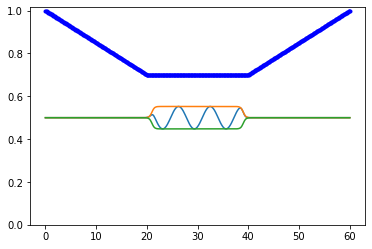

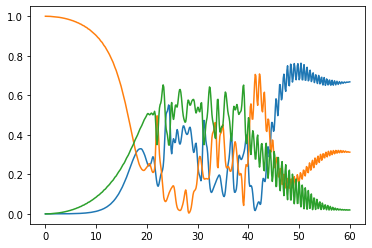

In [346]:
init_dict = {
    'decline_end':20.,
    'ascend_start':40.,
    'level':0.7,
    'envelope_amp':t.pi/60,
    'detuning':0.98,
    'phase':0.
    }
model = Flensmon(60, 500, N, init_dict)
model.optimizer = t.optim.Adam(model.parameters(),lr=1e-3)
# model.optimizer = t.optim.SGD(model.parameters(),lr=1e-2,momentum=0.0)

# model.scheduler = t.optim.lr_scheduler.CosineAnnealingLR(model.optimizer,T_max=10,eta_min=0)
# model.scheduler = t.optim.lr_scheduler.LambdaLR(model.optimizer,model.lr_func)

model.plot_activation_func()
model.plot_occupancy()
model.loss_func(model())

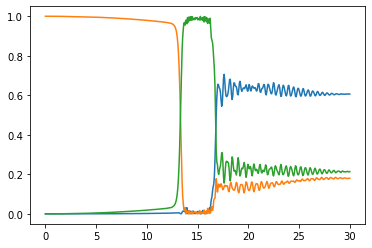

In [286]:
model.plot_occupancy()

In [257]:
list(model.parameters())

[Parameter containing:
 tensor(12.5105, requires_grad=True),
 Parameter containing:
 tensor(17.4894, requires_grad=True),
 Parameter containing:
 tensor(0.8763, requires_grad=True),
 Parameter containing:
 tensor(0.1652, requires_grad=True),
 Parameter containing:
 tensor(1.0052, requires_grad=True),
 Parameter containing:
 tensor(2.5000, requires_grad=True)]

In [351]:
model.epoch(0.001,1000)

initial loss: 0.004961295397467702
Ended at step: 294, with loss: 0.0009983744289924212 and runtime: 113.89398407936096


In [296]:
model.loss_func(model())

tensor([0.0093], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [350]:
list(model.parameters())

[Parameter containing:
 tensor(19.8847, requires_grad=True),
 Parameter containing:
 tensor(40.0587, requires_grad=True),
 Parameter containing:
 tensor(0.6922, requires_grad=True),
 Parameter containing:
 tensor(0.0654, requires_grad=True),
 Parameter containing:
 tensor(0.8568, requires_grad=True),
 Parameter containing:
 tensor(0.2057, requires_grad=True)]

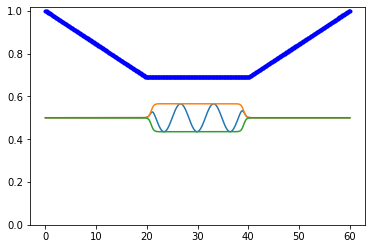

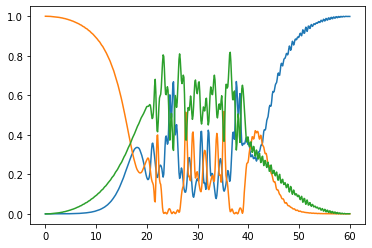

In [352]:
model.plot_activation_func()
model.plot_occupancy()

In [311]:
list(model.parameters())

[Parameter containing:
 tensor(12.7501, requires_grad=True),
 Parameter containing:
 tensor(17.2622, requires_grad=True),
 Parameter containing:
 tensor(0.9066, requires_grad=True),
 Parameter containing:
 tensor(0.4636, requires_grad=True),
 Parameter containing:
 tensor(0.9518, requires_grad=True),
 Parameter containing:
 tensor(2.6280, requires_grad=True)]